Urban Data Science & Smart Cities <br>
URSP688Y <br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/ncsg/ursp688y_sp2024/blob/main/exercises/exercise07/exercise07.ipynb)

# Exercise 7

## Problem

In week 7, you learned how to extend tabular data with geospatial information: points, linestrings, and polygons.

For this next exercise, please ask a planning-related question with a spatial component, then find data and apply any data science methods you have learned so-far (or can Google!) to answer that question.

## Data

You are welcome to use any data you would like, including data used in previous demos and exercises.

## A Few Pointers
- Choose a straightforward question that requires a reasonable amount of data! Don't shoot for the moon. This exercise is intended to give you a chance to practice finding and analyzing spatial data, not to address the world's greatest challenges.
- Consider using this exercise to get a head start on your final project or explore options for it. Your project doesn't need to focus on spatial analysis for it to play a role. Are there datasets you might join together based on spatial locations?
- Don't go overboard. If you're hitting a wall with coding, write pseudocode and turn that in. Don't let the perfect be the enemy of the done. But if you're energized and having fun by chasing down a thorny solution to a coding problem, by all means feel free to keep at it!



Proposal Title: Analyzing Bike Share Station Utilization Patterns in Ward 7, Washington, DC

Introduction:
Equitable access to sustainable transportation options, such as bike share systems, is a key priority for planners and policymakers aiming to improve mobility and quality of life for all residents. In Washington, DC, the Capital Bikeshare program has expanded rapidly since its launch in 2010, yet concerns remain about ensuring accessibility across different neighborhoods.

Ward 7, located in the eastern part of the city, has historically faced transportation challenges and limited access to various mobility options. Understanding the distribution and usage patterns of bike share stations in this community can provide valuable insights to guide future planning and investment decisions.

Research Questions:
1. How are bike share stations distributed spatially within Ward 7, and are there any areas with limited station coverage?
2. What station-level characteristics (e.g., station capacity, nearby land use) are associated with higher bike share utilization in Ward 7?

In [1]:
# # mount drive
# from google.colab import drive
# drive.mount('/content/drive')

#########################################################################################
# SET THIS PATH AS A WORKING DIRECTORY SO IT DOESN'T HAVE TO BE REPEATED FOR EVERY LOAD #
#########################################################################################
# # Set the working directory
# os.chdir('/content/drive/MyDrive/Amanguah/URSP668Y_Data_Science/Amanguah_Exercise_folder/new_data/')

In [2]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
import requests
import json
from shapely.geometry import Point
import folium
import matplotlib.pyplot as plt

In [3]:
wards_dc = gpd.read_file('wards_dc')
ward7_boundary = wards_dc[wards_dc['WARD'] == 7]
# Load census tract data
census_tracts = gpd.read_file('census_tracts')
# Load zoning designated data
zoning = gpd.read_file('Zoning_Downtown_Designated_Streets')
# load street centerlines or characteristics data
street_centerlines = gpd.read_file('Street_Centerlines_2013')
# Load bikeshare trip data
bikeshare_trip_data = pd.read_csv('202312-capitalbikeshare-tripdata/202312-capitalbikeshare-tripdata.csv')

In [4]:
# URL of the station information API endpoint
url = "https://gbfs.lyft.com/gbfs/2.3/dca-cabi/en/station_information.json"

# Send a GET request to the API endpoint
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Save the station data to a file
    with open("bike_stations.json", "w") as file:
        file.write(response.text)
    print("Station data downloaded successfully!")
else:
    print("Failed to download station data.")

# Load the JSON data
with open("bike_stations.json", "r") as file:
    data = json.load(file)
# Convert the data to a pandas DataFrame
bikeshare_station = pd.DataFrame(data["data"]["stations"])
# Convert the bikeshare_station DataFrame to a GeoDataFrame
bikeshare_station_gdf = gpd.GeoDataFrame(bikeshare_station, geometry=gpd.points_from_xy(bikeshare_station['lon'], bikeshare_station['lat']), crs='EPSG:4326')


Station data downloaded successfully!


Research Question 1: How are bike share stations distributed spatially within Ward 7, and are there any areas with limited station coverage?

Approach to Answering question one

In [5]:
# Store the EPSG code for UTM18
UTM18 = 26918

# Store the EPSG code for WGS84
WGS84 = 4326

#######################################################
# PROJECT EVERYTHING INTO UTM18 FIRST FOR CONSISTENCY #
########################################################
bikeshare_station_gdf = bikeshare_station_gdf.to_crs(epsg=UTM18)
ward7_boundary = ward7_boundary.to_crs(epsg=UTM18)
census_tracts = census_tracts.to_crs(epsg=UTM18)

# Perform spatial join
bikeshare_stations_in_ward7 = gpd.sjoin(bikeshare_station_gdf, ward7_boundary, how='inner', predicate='within')

# Calculate the centroid of each census tract
census_tracts['centroid'] = census_tracts.centroid

# Find the nearest bike share station for each census tract centroid
def find_nearest_station(row):
    nearest_station = min(bikeshare_stations_in_ward7.geometry, key=lambda g: g.distance(row.centroid))
    return nearest_station

census_tracts['nearest_station'] = census_tracts.apply(find_nearest_station, axis=1)

# Calculate the distance from each census tract centroid to the nearest bike share station
census_tracts['nearest_station_dist'] = census_tracts.apply(lambda row: row.centroid.distance(row.nearest_station), axis=1)
census_tracts['nearest_station_dist']


0      5067.836568
1      4283.050919
2      1540.251899
3      9831.500234
4      6221.186400
          ...     
201    5718.747079
202    5190.068816
203    5075.045130
204    4002.201529
205    4507.144595
Name: nearest_station_dist, Length: 206, dtype: float64

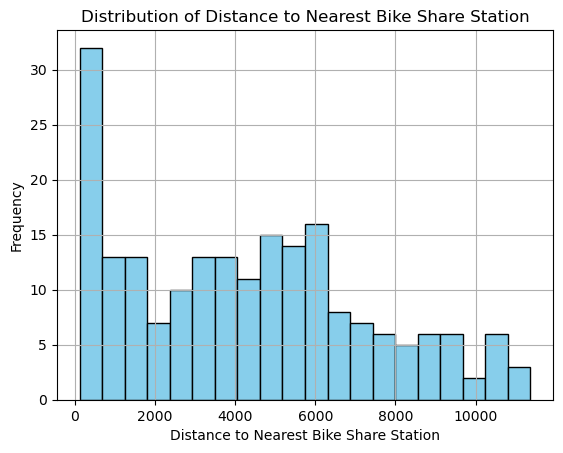

In [6]:
# Plot a histogram of nearest station distances
plt.hist(census_tracts['nearest_station_dist'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Distance to Nearest Bike Share Station')
plt.ylabel('Frequency')
plt.title('Distribution of Distance to Nearest Bike Share Station')
plt.grid(True)

plt.show()

In [7]:
#################################################################################
# NEED TO DROP OTHER COLUMNS WITH GEOMETRIES STORED IN THEM BECAUSE             #
# THE .GeoJSON METHOD IS EXPECTING A GEODATAFRAME WITH ONLY ONE GEOMETRY COLUMN #
#################################################################################
for col in ['centroid','nearest_station']:
    if col in census_tracts.columns:
        census_tracts = census_tracts.drop(columns=[col])

################################################################################
# PROJECT EVERYHING INTO WGS84 BECAUSE FOLIUM REQUIRES LAT AND LON COORDINATES #
################################################################################
bikeshare_stations_in_ward7 = bikeshare_stations_in_ward7.to_crs(WGS84)
census_tracts = census_tracts.to_crs(WGS84)

# Create a map centered on Ward 7
ward7_centroid = census_tracts.geometry.unary_union.centroid
m = folium.Map(location=[ward7_centroid.y, ward7_centroid.x], zoom_start=12)

# Add the census tract boundaries to the map
folium.GeoJson(census_tracts, name='census_tracts').add_to(m)

# Add the bike share station locations to the map
for idx, station in bikeshare_stations_in_ward7.to_crs(WGS84).iterrows():
    folium.Marker(
        location=[station.geometry.y, station.geometry.x],
        popup=station['name'],
        icon=folium.Icon(color='blue', icon='bicycle')
    ).add_to(m)
# Create a choropleth map to visualize the accessibility metrics
if 'nearest_station_dist' in census_tracts.columns:
    census_tracts_geojson = census_tracts.to_json()

    #####################################################################
    # Choropleth IS A CLASS WITHIN Folium, NOT A METHOD OF A Folium.Map #
    #####################################################################
    folium.Choropleth(
        geo_data=census_tracts_geojson,
        name='Accessibility',
        data=census_tracts,
        columns=['NAME', 'nearest_station_dist'],
        key_on='feature.properties.NAME',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Distance to Nearest Bike Share Station (meters)'
    
    ####################################################
    # THEN NEED TO ADD THE Choropleth CLASS TO THE MAP #
    ####################################################
    ).add_to(m)
else:
    print("The 'nearest_station_dist' column does not exist in the census_tracts GeoDataFrame.")

# Add a layer control to the map
folium.LayerControl().add_to(m)

# Display the map
m

Question 2:  What station-level characteristics (e.g., station capacity, nearby land use) are associated with higher bike share utilization in Ward 7?

Working towards answering question 2 below:

In [8]:
###########################################################################################
# NEED TO INCLUDE THE CRS ARGUMENT SPECIFYING THAT THIS IS IN THE WGS84 COORDINATE SYSTEM #
# THIS IS WHAT WAS PUTTING THE POINTS IN THE WRONG PART OF THE WORLD IN THE LAST MAP      #
###########################################################################################
bikeshare_station_gdf = gpd.GeoDataFrame(
    bikeshare_station_gdf, 
    geometry=gpd.points_from_xy(bikeshare_station_gdf['lon'], bikeshare_station_gdf['lat']), 
    crs=WGS84)

# Reproject the geometries to a common coordinate system (UTM18)
bikeshare_station_gdf = bikeshare_station_gdf.to_crs(epsg=UTM18)
zoning = zoning.to_crs(epsg=UTM18)
street_centerlines = street_centerlines.to_crs(epsg=UTM18)

# Extract relevant station-level features
station_level_features = bikeshare_station_gdf[['station_id', 'name', 'capacity', 'lon', 'lat']]

In [9]:
# Merge the station level features data with the zoning data based on a common key
bikeshare_stations_with_zoning = gpd.sjoin(bikeshare_station_gdf, zoning, how='left', predicate='intersects')

In [10]:
# Convert 'started_at' and 'ended_at' columns to datetime objects
bikeshare_trip_data['started_at'] = pd.to_datetime(bikeshare_trip_data['started_at'])
bikeshare_trip_data['ended_at'] = pd.to_datetime(bikeshare_trip_data['ended_at'])

# Calculate trip duration in seconds
bikeshare_trip_data['trip_duration'] = (bikeshare_trip_data['ended_at'] - bikeshare_trip_data['started_at']).dt.total_seconds()

# Group the trip data by start station and calculate utilization metrics
station_utilization = bikeshare_trip_data.groupby('start_station_id')[['trip_duration']].agg(['count', 'mean'])
station_utilization.columns = ['total_trips', 'avg_trip_duration']
station_utilization = station_utilization.reset_index()
station_utilization.head(2)

##############################################################################################################################
# THIS STEP DOESN'T SEEM NECESSARY AND PUTS bikeshare_stations_with_zoning IN THE WRONG PROJECTION FOR THE FOLIUM MAP, BELOW #
##############################################################################################################################
# Re-project the 'bikeshare_stations_with_zoning' DataFrame to a common CRS
# bikeshare_stations_with_zoning = bikeshare_stations_with_zoning.to_crs(epsg=3857)

# Merge the station-level features and utilization metrics
bikeshare_stations_with_data_combined_df = pd.concat([bikeshare_stations_with_zoning, station_utilization], axis=1)
bikeshare_stations_with_data_combined_df.head(2)

name short_name        lat region_id  \
0  New Hampshire & Kirklynn Ave      32061  38.988101        44   
1    The Mall at Prince Georges      32422  38.968842       133   

                                         rental_uris  capacity        lon  \
0  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...        15 -76.988422   
1  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...        17 -76.954171   

                             station_id                        geometry  \
0  082650b1-1f3f-11e7-bf6b-3863bb334450  POINT (327782.690 4317336.684)   
1  d34d2639-ee43-4892-818f-f01116813744  POINT (330703.527 4315134.990)   

   index_right CATEGORY GIS_ID  OBJECTID GLOBALID  SHAPELEN  start_station_id  \
0          NaN      NaN    NaN       NaN      NaN       NaN           30200.0   
1          NaN      NaN    NaN       NaN      NaN       NaN           30201.0   

   total_trips  avg_trip_duration  
0        590.0        1734.744068  
1        967.0         895.328852

In [11]:
bikeshare_stations_with_zoning

name short_name        lat  \
0                       New Hampshire & Kirklynn Ave      32061  38.988101   
1                         The Mall at Prince Georges      32422  38.968842   
2    Vaden Dr & Royal Victoria Dr/Jim Scott Cmty Ctr      32261  38.873261   
3                            Braddock Rd Metro North      31047  38.814577   
4                   Constitution Ave & 2nd St NW/DOL      31271  38.892275   
..                                               ...        ...        ...   
775                                    5th & K St NW      31600  38.903040   
776                        Wiehle-Reston Metro South      32215  38.946608   
777                        17th St & New York Ave NW      33200  38.896604   
778                                   24th & N St NW      31255  38.906600   
779                          Monroe Ave & Leslie Ave      31087  38.820932   

    region_id                                        rental_uris  capacity  \
0          44  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...        15   
1         133  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...        17   
2         104  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...        11   
3          40  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...        29   
4          42  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...        27   
..        ...                                                ...       ...   
775        42  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...        19   
776       104  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...        19   
777        42  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...        15   
778        42  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...        15   
779        40  {'ios': 'https://dc.lft.to/lastmile_qr_scan', ...        15   

           lon                            station_id  \
0   -76.988422  082650b1-1f3f-11e7-bf6b-3863bb334450   
1   -76.954171  d34d2639-ee43-4892-818f-f01116813744   
2   -77.272999  f08db1df-054a-46c8-a3e1-b349f2a26d5e   
3   -77.052808  08253c6b-1f3f-11e7-bf6b-3863bb334450   
4   -77.013917  08256d91-1f3f-11e7-bf6b-3863bb334450   
..         ...                                   ...   
775 -77.019027  08247d46-1f3f-11e7-bf6b-3863bb334450   
776 -77.339391  08263b08-1f3f-11e7-bf6b-3863bb334450   
777 -77.039778  47ea64ba-00cd-4762-a90c-240244d1e4c8   
778 -77.051520  08253e02-1f3f-11e7-bf6b-3863bb334450   
779 -77.053096  0825f9b6-1f3f-11e7-bf6b-3863bb334450   

                           geometry  index_right CATEGORY GIS_ID  OBJECTID  \
0    POINT (327782.690 4317336.684)          NaN      NaN    NaN       NaN   
1    POINT (330703.527 4315134.990)          NaN      NaN    NaN       NaN   
2    POINT (302815.080 4305167.818)          NaN      NaN    NaN       NaN   
3    POINT (321772.208 4298202.050)          NaN      NaN    NaN       NaN   
4    POINT (325339.309 4306750.047)          NaN      NaN    NaN       NaN   
..                              ...          ...      ...    ...       ...   
775  POINT (324922.548 4307954.584)          NaN      NaN    NaN       NaN   
776  POINT (297263.690 4313454.092)          NaN      NaN    NaN       NaN   
777  POINT (323107.018 4307280.338)          NaN      NaN    NaN       NaN   
778  POINT (322113.602 4308412.577)          NaN      NaN    NaN       NaN   
779  POINT (321763.051 4298907.908)          NaN      NaN    NaN       NaN   

    GLOBALID  SHAPELEN  
0        NaN       NaN  
1        NaN       NaN  
2        NaN       NaN  
3        NaN       NaN  
4        NaN       NaN  
..       ...       ...  
775      NaN       NaN  
776      NaN       NaN  
777      NaN       NaN  
778      NaN       NaN  
779      NaN       NaN  

[780 rows x 15 columns]

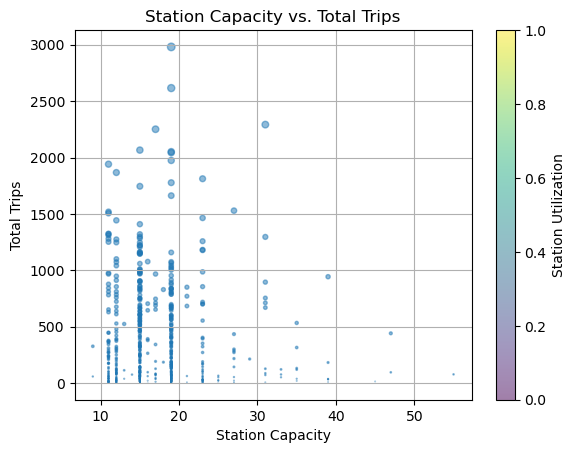

In [12]:
import matplotlib.pyplot as plt

# Define marker size based on station utilization
marker_size = bikeshare_stations_with_data_combined_df['total_trips'] / 100

# Create a bubble plot of station capacity vs. total trips
plt.scatter(bikeshare_stations_with_data_combined_df['capacity'],
            bikeshare_stations_with_data_combined_df['total_trips'],
            s=marker_size, alpha=0.5)

plt.xlabel('Station Capacity')
plt.ylabel('Total Trips')
plt.title('Station Capacity vs. Total Trips')

# Add a color bar legend for marker sizes
plt.colorbar(label='Station Utilization')

plt.grid(True)
plt.show()

In [13]:
# Calculate correlation between station capacity and total trips
correlation = bikeshare_stations_with_data_combined_df[['capacity', 'total_trips']].corr().iloc[0, 1]
print(f'Correlation between station capacity and total trips: {correlation:.2f}')

Correlation between station capacity and total trips: -0.02


In [15]:
######################################################
# MAKE SURE THINGS ARE PROJECTED IN WGS84 FOR FOLIUM #
######################################################
bikeshare_stations_with_data_combined_df = bikeshare_stations_with_data_combined_df.to_crs(WGS84)

# Create a map centered on Ward 7
ward7_centroid = bikeshare_stations_with_data_combined_df.geometry.unary_union.centroid

m = folium.Map(location=[ward7_centroid.y, ward7_centroid.x], zoom_start=12)

# Add the bike share stations to the map, colored by utilization
for _, row in bikeshare_stations_with_data_combined_df.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row['name'],
        icon=folium.Icon(color='blue' if row['total_trips'] < 1000 else 'red', icon='bicycle')
    ).add_to(m)

# Add the zoning information to the map
folium.GeoJson(zoning, name='Zoning').add_to(m)

# Display the map
m